In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt

# Loading data

In [2]:
# Open files
X_train = pd.read_csv('data/challenge_fichier_dentrees_dentrainement_challenge_nba/train.csv')
Y_train = pd.read_csv('data/challenge_fichier_de_sortie_dentrainement_challenge_nba.csv', sep=';')
#X_test = pd.read_csv('data/challenge_fichiers_dentrees_de_test_challenge_nba/test.csv')

# Data description

In [3]:
# Parameters
nb_games_train = len(X_train)
nb_games_test = len(X_test)
print("Number of games (train): {}".format(nb_games_train))
print("Number of games (test): {}".format(nb_games_test))

NameError: name 'X_test' is not defined

Dataset from the 15 last NBA seasons.
One line = one game described by every second (1440) of the first half of the game. Every second is described by 11 variables (11x1440 = 15840 columns).
The variables are the following:
* score
* offensive rebound
* defensive rebound
* offensive foul
* defensive foul
* assist
* lost ball
* steals
* bad pass
* block
* miss

They represent the difference between indicators of invited team - home team.

Winning team is 1 if it's the invited team, 0 oterhwise.

In [4]:
X_train.head()

,ID,score_1,offensive rebound_1,defensive rebound_1,offensive foul_1,defensive foul_1,assist_1,lost ball_1,steals_1,bad pass_1,...,offensive rebound_1440,defensive rebound_1440,offensive foul_1440,defensive foul_1440,assist_1440,lost ball_1440,steals_1440,bad pass_1440,block_1440,miss_1440
0,14186,-2,0,0,0,0,0,0,0,0,...,8,-4,2,0,-3,3,3,-2,1,9
1,13013,0,0,-1,0,0,0,0,0,0,...,1,5,0,0,1,0,0,1,-2,-1
2,7102,0,0,0,0,0,0,0,1,1,...,-1,-5,-5,0,0,5,5,-2,3,-5
3,7637,-2,0,0,0,0,0,0,0,0,...,2,8,1,0,-1,-1,2,2,-1,-1
4,12350,0,0,0,0,0,0,0,0,0,...,4,1,0,0,4,3,2,1,1,3


In [5]:
Y_train.head(10)

,ID,label
0,14186,0
1,13013,0
2,7102,0
3,7637,1
4,12350,0
5,4243,1
6,5202,0
7,17817,0
8,2422,0
9,2147,1


# Data exploration

**Reference metric : based on the score at the end of the second quarter**

In [37]:
# Prediction
score_nd_quarter = X_train['score_1440'].as_matrix()
winner_nd_quarter = np.ones(nb_games_train)*(score_nd_quarter[:] > 0)

# Ground Truth
winner = Y_train['label'].as_matrix()

# Accuracy
ref = accuracy_score(winner,winner_nd_quarter)

print('Reference accuracy : {:.1f}%'.format(ref*100))

Reference accuracy : 72.1%


**If using score at the end of the first quater**

In [38]:
# Prediction
score_st_quarter = X_train['score_720'].as_matrix()
winner_st_quarter = np.ones(nb_games_train)*(score_st_quarter[:] > 0)

# Accuracy
ref = accuracy_score(winner,winner_st_quarter)

print('Accuracy at the end of the first quater: {:.1f}%'.format(ref*100))

Accuracy at the end of the first quater: 64.9%


**Using score at time t to predict the winner at the end of the game**

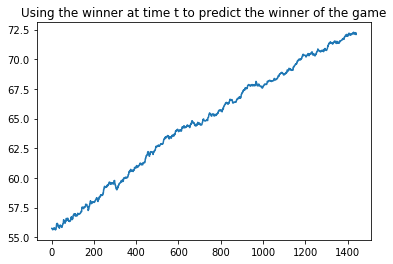

In [39]:
def score_winner(score_at_t, winner):
    '''What if using score at time t to predict the winner at the end of the game ?'''
    acc = np.mean((score_at_t>0) == winner)
    return 100*acc

history = []
for i in range(1, 1440+1, 1):
    history.append(score_winner(X_train['score_'+str(i)], winner))
    
plt.plot(range(1, 1440+1, 1), history)
plt.title("Using the winner at time t to predict the winner of the game")
plt.show()

**Using other variables at time t to predict the winner at the end of the game**

It shows a sort of correlation between some variables and the winning team. 'defensive foul' seems to have no impact on the winning team.

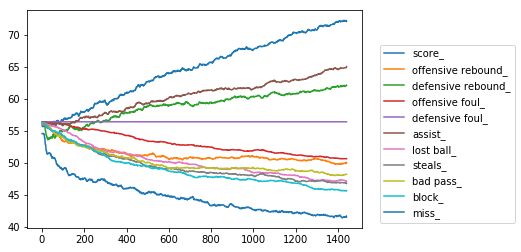

In [61]:
columns_names = ['score_', 
                 'offensive rebound_', 'defensive rebound_', 
                 'offensive foul_', 'defensive foul_',
                 'assist_',
                 'lost ball_', 'steals_',
                 'bad pass_', 'block_', 'miss_']

plt.figure()

for variable in columns_names:
    history = []
    for i in range(1, 1440+1, 1):
        history.append(score_winner(X_train[variable+str(i)], winner))
    plt.plot(range(1, 1440+1, 1), history, label = variable)

plt.legend(loc = 'lower left', bbox_to_anchor = (1.04,0))
plt.show()

# Project data to PCA space

* No obvious structure on the raw features. 
* Second component can only take particular value (between -1, 0, 1 and 2).
* Lots of superposition over the points suggesting that it would be interesting to study the nearest neightbor approach.

In [6]:
X = X_train.loc[:, X_train.columns != 'ID'].as_matrix()
projection = PCA(n_components = 2)
X_projected = projection.fit_transform(X)
print('Proportion of variance explained: {}'.format(projection.explained_variance_ratio_))

Proportion of variance explained: [0.49430529 0.12792219]


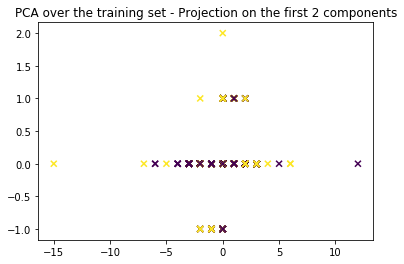

In [7]:
Y = Y_train['label'].as_matrix()
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = 'x')
plt.title('PCA over the training set - Projection on the first 2 components')
plt.show()

# Project data to T-SNE space

* More comprehensible structure. 
* Higly non-linear and complex separation

In [9]:
pca_reducing = PCA(n_components=50)
X_reduced = pca_reducing.fit_transform(X)

projection_tsne = TSNE(n_components = 2)
X_projected_tsne = projection_tsne.fit_transform(X_reduced)

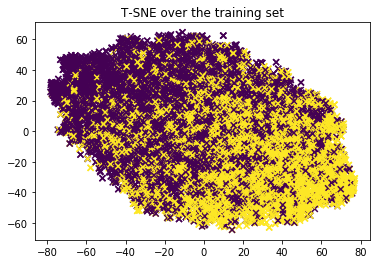

In [10]:
plt.scatter(X_projected_tsne[:, 0], X_projected_tsne[:, 1], c = Y, marker = 'x')
plt.title('T-SNE over the training set')
plt.show()

# Correlation

In [69]:
X_train_1440_label = pd.concat([X_train.filter(regex=("[a-zA-Z]+_1440")), Y_train['label']], axis = 1)
X_train_1440_label = X_train_1440_label.iloc[:, X_train_1440_label.columns != 'defensive foul_1440']

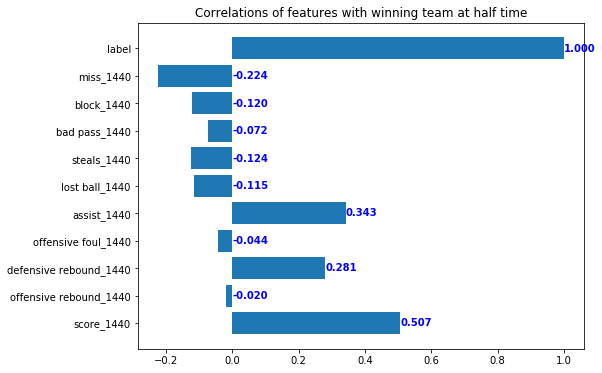

In [109]:
correlations = X_train_1440_label.corr()
corr_label = np.array(correlations['label'])


fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

ax.barh(np.arange(len(corr_label)), corr_label)
ax.set_yticks(np.arange(len(corr_label)))
ax.set_yticklabels(correlations.columns)
for i, v in enumerate(corr_label):
    ax.text(max(v, 0), i-.1, "{0:.3f}".format(v), color='blue', fontweight='bold')
ax.set_title('Correlations of features with winning team at half time')
plt.show()

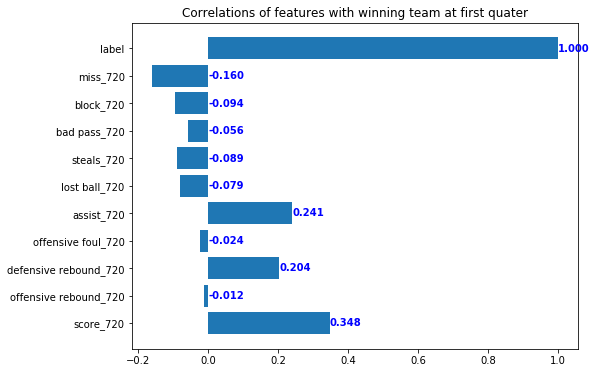

In [112]:
X_train_720_label = pd.concat([X_train.filter(regex=("[a-zA-Z]+_720")), Y_train['label']], axis = 1)
X_train_720_label = X_train_720_label.iloc[:, X_train_720_label.columns != 'defensive foul_720']

correlations = X_train_720_label.corr()
corr_label = np.array(correlations['label'])


fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

ax.barh(np.arange(len(corr_label)), corr_label)
ax.set_yticks(np.arange(len(corr_label)))
ax.set_yticklabels(correlations.columns)
for i, v in enumerate(corr_label):
    ax.text(max(v, 0), i-.1, "{0:.3f}".format(v), color='blue', fontweight='bold')
ax.set_title('Correlations of features with winning team at first quater')
plt.show()

In [110]:
1440/2

720.0